In [1]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import gc

module_dir = os.path.abspath('../src/')
sys.path.append(module_dir)

from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf
import parser_fun as pf

import analysis_functions as af
import HE_analysis_functions as afHE
import stats
import utility as ut

#Can be removed later
import importlib
importlib.reload(afHE)
from sklearn.cluster import DBSCAN
#

In [2]:
run_number = 15607
folderdata = [f"/scratch/torellis/NEXTResoAnalysis/data/{run_number}/trg2/ldc1"]

In [4]:
df = pf.merge_hdfs_multi(folderdata)

In [5]:
dfs1s2sel = df[ (df['nS1']==1) & (df['nS2']==1) ]
print(f"NEvent filtered road : {len(np.unique(dfs1s2sel['event']))}")
print(f"eff:{(len(np.unique(dfs1s2sel['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 52601
eff:28.48%


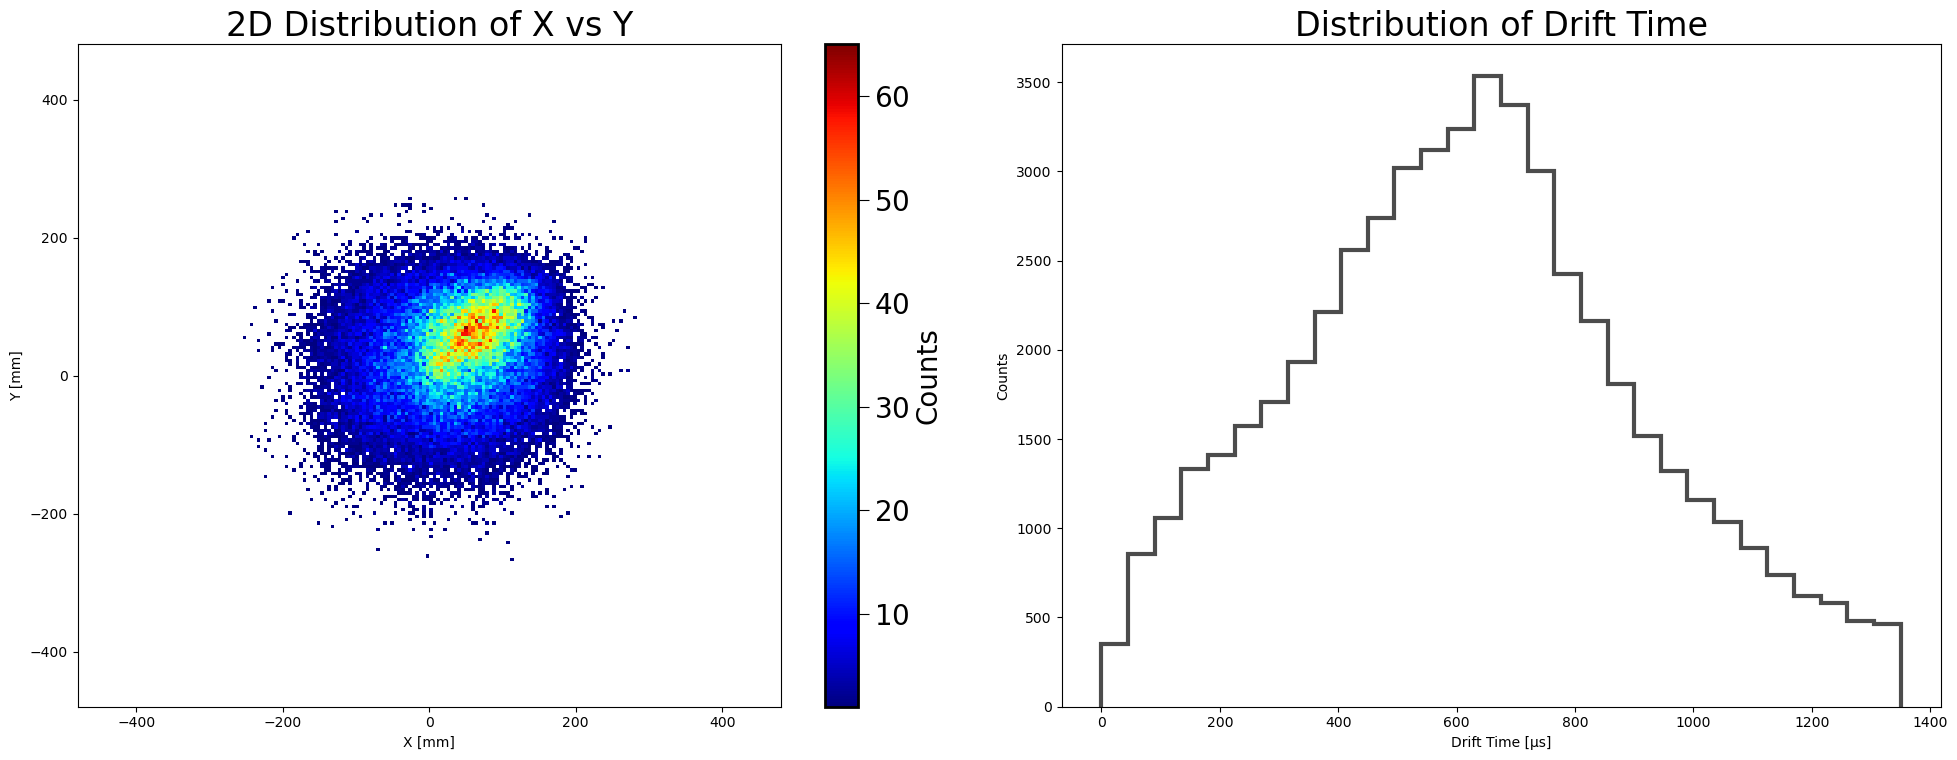

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
auto_plot_style()  # Assuming this sets fonts and colors

# --- 2D Histogram of X vs Y ---
H, xedges, yedges = np.histogram2d(
    dfs1s2sel['X'], dfs1s2sel['Y'],
    bins=(200, 200), range=((-480, 480), (-480, 480))
)
H = np.where(H == 0, np.nan, H)  # Mask zero counts

pcm = axes[0].pcolormesh(xedges, yedges, H.T, cmap='jet')
axes[0].set_xlabel('X [mm]')
axes[0].set_ylabel('Y [mm]')
axes[0].set_title('2D Distribution of X vs Y')

# Add colorbar
fig.colorbar(pcm, ax=axes[0], label='Counts')

# --- Histogram of Drift Time (DT) ---
axes[1].hist(
    dfs1s2sel['DT'],
    bins=30, range=(0, 1350),
    histtype='step',
    color=color_sequence[0],
    alpha=0.7
)
axes[1].set_xlabel('Drift Time [μs]')
axes[1].set_ylabel('Counts')
axes[1].set_title('Distribution of Drift Time')

# Final layout
plt.tight_layout()
plt.show()

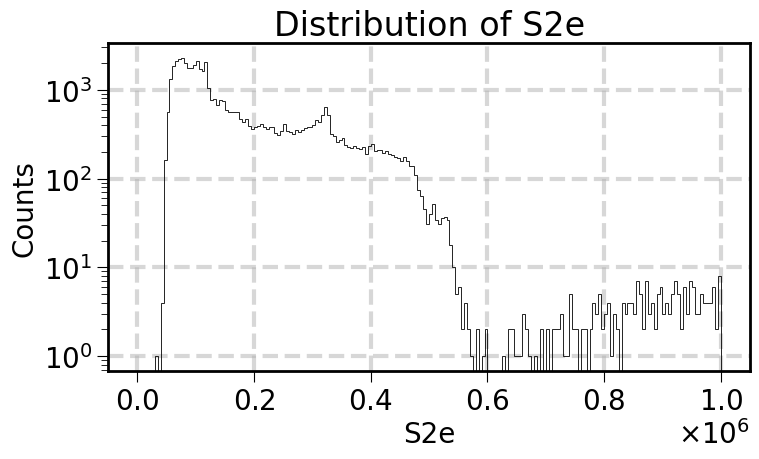

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(dfs1s2sel['S2e'], bins=200, range=(0,1e6), histtype='step',linewidth = .6)
plt.xlabel('S2e')
plt.ylabel('Counts')
plt.title('Distribution of S2e')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
ev_list = list(dfs1s2sel[(dfs1s2sel['S2e']>0.2e6) & (dfs1s2sel['S2e']<0.65e6)]['event'].unique())

In [ ]:
del df,dfs1s2sel
gc.collect()

In [9]:
kr_map = af.load_kr_map('../db/kr_maps/average_map_15614_15615.npz')

In [ ]:
importlib.reload(afHE)
importlib.reload(pf)
run_number = 15607
folderdata = [f"/scratch/torellis/NEXTResoAnalysis/data/{run_number}/trg2/ldc1/"]
df = afHE.preprocess_df_hits(folderdata,ev_list,'../db/kr_maps/average_map_15614_15615.npz')

recomended to pass 1 ldc per time!!
opening...
clustering...
